In [18]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [19]:
def branin(X, Y):
    a = 1.0
    b = 5.1 / (4.0 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8.0 * np.pi)
    
    return a * (Y - b * X**2 + c * X - r)**2 + s * (1 - t) * np.cos(X) + s


In [20]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [21]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, a, b: 0.1*(a - 4) * x + 0.05*(b + 3) * x**2 + r.normal(0, sim_stdev)

In [22]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 10, 10)
Y = np.random.uniform(0, 15, 10)

# Calculate the outputs using Branin and Currin functions
output1 = branin(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [23]:
sim_eval = lambda x, y, a, b: branin(x, y) + sim_err(x, a, b)

In [24]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (2,5)},
          {'name': 'b', 'type': 'continuous', 'domain': (-4,-1)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.95963037 -3.00534208]


In [25]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


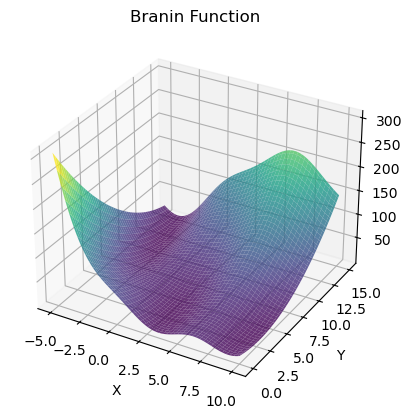

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 10, 100)
y_range = np.linspace(0, 15, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = branin(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ackley Function')

# Show the plot
plt.show()

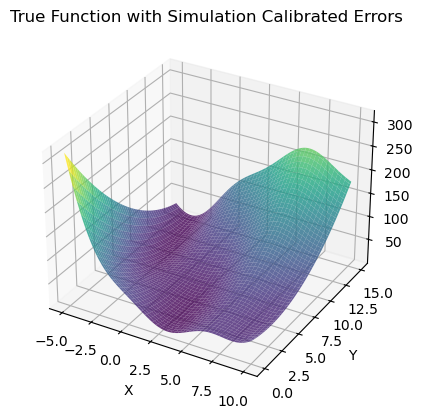

In [27]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[0])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [28]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [29]:
def perform_iteration(df):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-5, 10, 100)
    x2_range  = np.linspace(0, 15, 100)

    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions for entire meshgrid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Locating global Maximum of predicted mean
    max_index = np.argmax(pred_mean)
    global_max_point = x_grid[max_index]

    # Identify 10 points around global maximum
    num_new_points = 10
    lhs_sampler = qmc.LatinHypercube(d=2) 
    lhs_sample = lhs_sampler.random(num_new_points)

    # Scaling LHS samples to region around global maximum
    scaling_factor = 0.1  # Factor to control sampling range
    lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
    lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

    new_points = np.c_[lhs_x1, lhs_x2]

    # Store new simualted points to validate and sample
    new_points_df = pd.DataFrame(new_points, columns=['x', 'y'])

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot the high uncertainty points
    ax.scatter(new_points[:, 0], new_points[:, 1], pred_mean[max_index], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    # Add validated data points to original data frame
    new_points_df["z"] = branin(new_points_df['x'], new_points_df['y']) + ran_err(num_new_points, 0.05)
    new_points_df["a"] = bo.x_opt[0]
    new_points_df["b"] = bo.x_opt[1]
    new_points_df["sim_z"] = sim_eval(new_points_df["x"], new_points_df["y"], new_points_df["a"], new_points_df["b"])
    new_points_df["diff"] = new_points_df["z"] - new_points_df["sim_z"]

    df = pd.concat([df, new_points_df], axis=0, ignore_index=True)
    return df


Best hyperparameters:
num_layers: 7
num_units: 200
learning_rate: 0.0009052898234110244
dropout_rate: 0.312707311967144
batch_size: 150
epochs: 146
Epoch 1/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 7621.9351
Epoch 2/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7623.2510
Epoch 3/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7610.6963
Epoch 4/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7607.6807
Epoch 5/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7578.6768
Epoch 6/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7581.9233
Epoch 7/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7553.5845
Epoch 8/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7510.8936
Epoch 9/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7487.1709
Epoch 10/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7403.4141
Epoch 11/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7338.1001
Epoch 12/146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7208.2236
Epoch 13/146
1/1 ━━━━━━━━━━━━━━━━━━

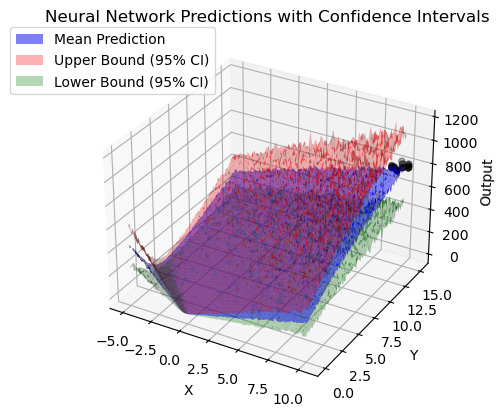

In [30]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.02488227691495056
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step - loss: 13383.1123
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 12812.7646
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 11675.6279
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9733.7725
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7148.3584
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4719.3423
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3194.1089
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2409.1382
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3195.8547
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3444.8867
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2731.4365
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2074.8218
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms

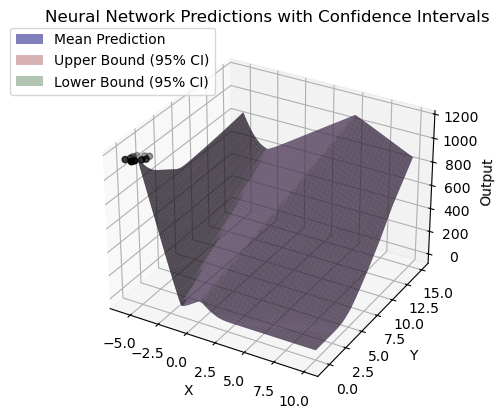

In [31]:
df = perform_iteration(df)

In [32]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


Best hyperparameters:
num_layers: 6
num_units: 121
learning_rate: 0.009510628302741617
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 41067.9727
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40827.5352 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19361.0312 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6794.7627 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4189.3994 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5280.2231 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5599.8862 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5286.3760 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3735.6931 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4201.3604 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2334.0095 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2105.1833 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

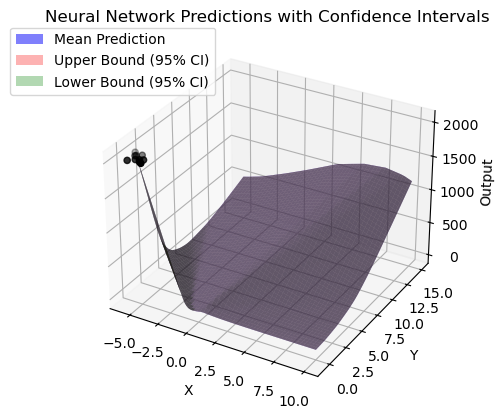

In [33]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 3
num_units: 50
learning_rate: 0.024489977542558463
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 59823.8438  
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56311.1406 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52244.0859 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44422.6172 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32690.8027 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18707.0605 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7103.7231 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7905.5615 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5709.2852 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3849.6111 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5745.9233 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6971.9189 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

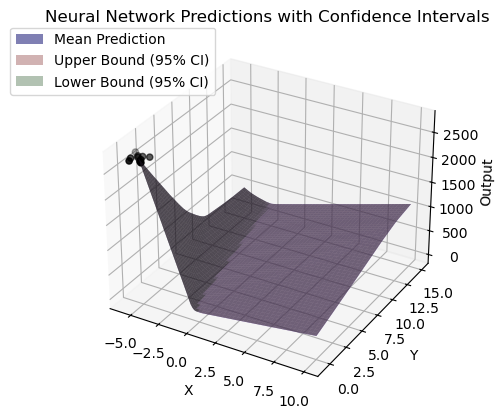

In [34]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 131
Epoch 1/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step - loss: 64223.9883
Epoch 2/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 52907.8242
Epoch 3/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 28802.4316
Epoch 4/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2733.9785
Epoch 5/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 30181.8848
Epoch 6/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5317.1899
Epoch 7/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8122.4902
Epoch 8/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 15284.3877
Epoch 9/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 15907.6963
Epoch 10/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 10398.0576
Epoch 11/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3012.2642
Epoch 12/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3314.0945
Epoch 13/131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss

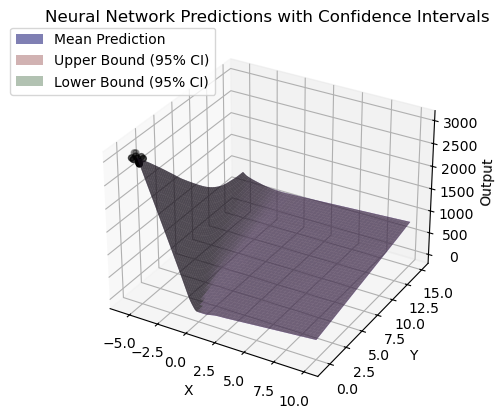

In [36]:
df = perform_iteration(df)

In [37]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.013912598411105577
dropout_rate: 0.0
batch_size: 22
epochs: 50
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 184559.2969
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61166.2461 
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 73515.6250 
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 61677.0938 
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42624.2266 
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33169.7031 
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48906.9961 
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27403.2910 
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11560.6494
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16773.4766 
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4735.5859 
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5657.5405 
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

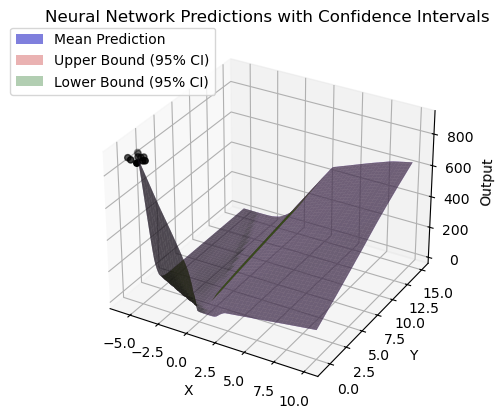

In [38]:
df = perform_iteration(df)

In [39]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
...,...,...,...,...,...,...,...
65,-4.630896,-0.690575,292.480003,3.95963,-3.005342,292.579664,-0.099661
66,-5.661256,-0.323196,396.939777,3.95963,-3.005342,397.100511,-0.160734
67,-4.310148,-0.088904,241.877547,3.95963,-3.005342,241.890674,-0.013127
68,-4.446684,-0.178743,257.412356,3.95963,-3.005342,257.511354,-0.098999


Best hyperparameters:
num_layers: 7
num_units: 200
learning_rate: 0.013398900134005498
dropout_rate: 0.15717111419908028
batch_size: 99
epochs: 101
Epoch 1/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 73542.6406
Epoch 2/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 70299.1016
Epoch 3/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 38638.8164
Epoch 4/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2404.7139
Epoch 5/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4349.0352
Epoch 6/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 107313.9766
Epoch 7/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 30547.4922
Epoch 8/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 61760.5703
Epoch 9/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 69884.2500
Epoch 10/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 71712.4844
Epoch 11/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 72221.8203
Epoch 12/101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 72264.5469
Epoch 13/101
1/1 ━━━━━

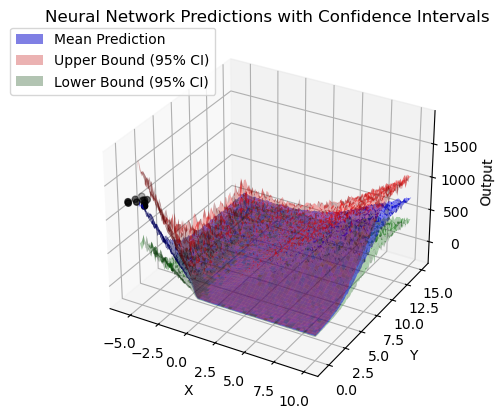

In [40]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 6
num_units: 73
learning_rate: 0.00014303257778852104
dropout_rate: 0.23488541825500767
batch_size: 102
epochs: 123
Epoch 1/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 76421.8047
Epoch 2/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 76415.4609
Epoch 3/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 76426.0625
Epoch 4/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 76408.2344
Epoch 5/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 76411.5938
Epoch 6/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 76407.2266
Epoch 7/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 76397.7031
Epoch 8/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 76392.7344
Epoch 9/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 76396.0234
Epoch 10/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 76388.2891
Epoch 11/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 76382.0781
Epoch 12/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 76377.4844
Epoch 13/123
1/1 ━━━━

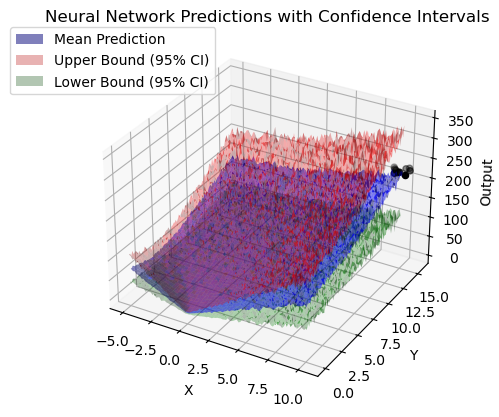

In [42]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.07162030145598255
dropout_rate: 0.0
batch_size: 72
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 69832.1172  
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 48523.5859 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8266.0967 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12327.0293 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5958.7612 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10115.8906 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4907.9365 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8232.1553 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4079.1106 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3911.0144 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2455.0491 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2438.3386 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

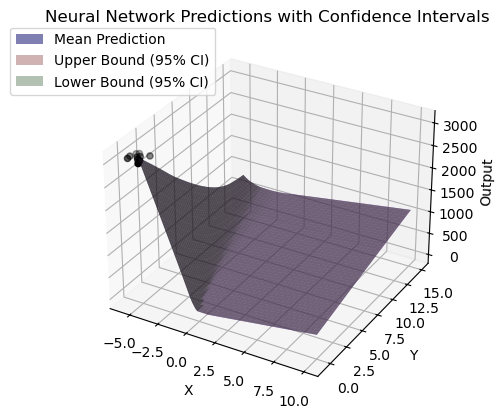

In [43]:
df = perform_iteration(df)

In [47]:
df
df.to_excel('data1.xlsx', sheet_name='Sheet1', index=False)

Best hyperparameters:
num_layers: 2
num_units: 179
learning_rate: 0.02936042557679281
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step - loss: 73446.8828
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 72145.0078
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 69367.0781
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 64277.5156
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 56515.1992
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 46468.6016
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 35796.1602
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 23421.3926
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 10474.2588
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2444.4963
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6168.0732
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 15375.0625
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 

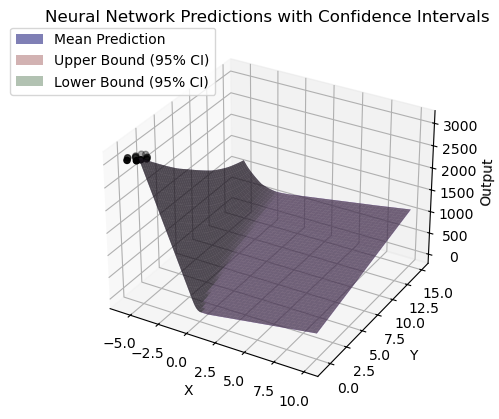

In [49]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.08967677795790222
dropout_rate: 0.5
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step - loss: 75826.5781
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 65817.6875
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 41580.7188
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5290.6006
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 51670.0938
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 12729.3848
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4687.1597
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12856.6865
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19684.9258
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 19530.4219
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 15190.2334
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8590.9072
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

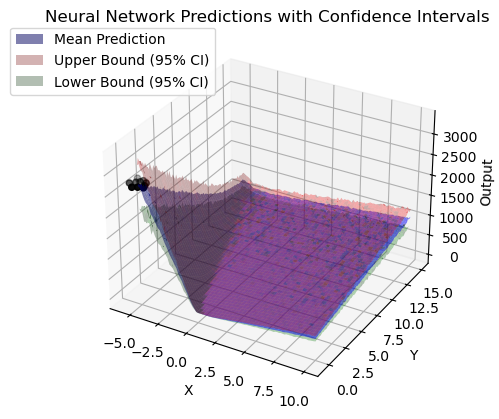

In [50]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.031329349623435365
dropout_rate: 0.5
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step - loss: 77320.1797
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 75691.6719
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 72063.3359
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 65251.2422
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 56060.3828
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 45012.6758
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 30232.2246
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 14162.8213
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2558.3953
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7043.1279
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 20006.4570
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 18919.5449
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━

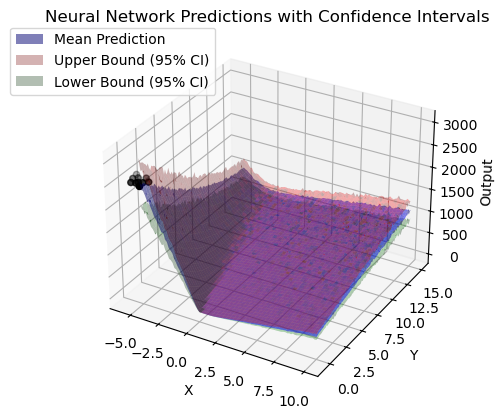

In [51]:
df = perform_iteration(df)